## Training HMMs when hidden states are truly unobserved

In this case we use a expectation maximization (EM) algorithm. The EM algorithm is useful whenever we have to marginalize over an unknown (hidden) variable. Our likelihood is $p(x) = \sum_{z} p(x, z)$.

The E step of the EM algorithm implies computing the analogue of the counting in the case of observed $z$ s. The thing is that, now, these countings depend on $A, B, \pi, \alpha$ and $\beta$ themselves (so we actually need the forward-backward algorithms at this point). The fact that we cannot count directly is caused by the unobserved nature of the $z$ s.

E step:
$$
\xi_t(i,j) = \frac{\alpha_t(i)A_{i,j}B_{j,x_{t+1}}\beta_{t+1}(j)}{\sum_{i=1}^M\sum_{j=1}^M\alpha_t(i)A_{i,j}B_{j,x_{t+1}}\beta_{t+1}(j)}\,,\\

\gamma_t(i) = \sum_{j=1}^M \xi_t(i,j)
$$

The M step now computes $\pi, A$ and $B$ from the quantities $\xi$ and $\gamma$

M step:

$$
\pi_i = \gamma_1(i)\,,\\
A_{i,j} = \frac{\sum_{t=1}^{T-1}\xi_t(i,j)}{\sum_{t=1}^{T-1}\gamma_t(i)}\,,\\
B_{j,k} = \frac{\sum_{t=1}^{T}\gamma_t(j)\mathbb{1}(x_t=k)}{\sum_{t=1}^{T}\gamma_t(j)}\,,
$$

This is an iterative algorithm that starts from guessed values for $A$, $B$ and $\pi$ and iterates until convergence. The EM algorithm applied to HMMs (the above algorithm) is actually called `Baum-Welch` algorithm. It ensures only convergence to a *local* maximum, and so one could perform more than one training (starting from different initial points in parameter space) and keep the best final model.

## Choose the number of hidden states

When states $z$ are really unobserved, we do not know how many hidden states to choose ($M$). This needs to be treated as a hyperparameter of the model. For example, we can choose the $M$ that maximizes the log-lokelihood of the resulting model.

Another possibility is to use AIC or BIC, that choose the best model penalizing for the number of parameters (on the training set only!)

$$ AIC = 2p- 2 \log L\,,\\
BIC = p\log N -2\log L\,,
$$
where $p$ is the number of parameters. We can choose the minimum (best) AIC or BIC after evaluating on different $M$s

## Baum-Welch algorithm for multiple observations

We index each observation (each sequence) in our training set by $n$, with $n=1,..., N$. Now we will have $N$ training sequences and, for each one, we will be able to compute a $\alpha_n\,, \beta_n$. There will be also a overall probability of the sequence $P_n$ and a length that of course depends on the sequence (called $T_n$).

With this we can use the generalization of our previous formulas (now explicit in $\alpha, \beta$) as:
$$
\pi_i = \frac{1}{N}\sum_{n=1}^N \frac{\alpha_n(1,i)\beta_n(1,i)}{P_n}\,,\\
A_{ij} = \frac{\sum_{n=1}^N \frac{1}{P_n} \sum_{t=1}^{T_n-1}\alpha_n(t,i)A_{ij}B_{j, x_n(t+1)}\beta_n(t+1,j)}{\sum_{n=1}^N \frac{1}{P_n} \sum_{t=1}^{T_n-1}\alpha_n(t,i)\beta_n(t,i)}\,,\\
B_{jk} = \frac{\sum_{n=1}^N \frac{1}{P_n} \sum_{t=1}^{T_n}\alpha_n(t,j)\beta_n(t,j) \mathbb{1}(x_n(t)=k)}{\sum_{n=1}^N \frac{1}{P_n} \sum_{t=1}^{T_n}\alpha_n(t,j)\beta_n(t,j)}\,,
$$




In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Class HMM that fits the parameters and makes an inference

In [2]:
# create a valid random markov matrix
def random_normalized(dim1, dim2):
    """
    Creates a matrix of random numbers that are compatible with Markov
    (namely, they rows sum up to 1)
    """
    random_matrix = np.random.rand(dim1, dim2)
    #divide by sum over rows to make rows add up to 1 (Markov matrix)
    return random_matrix/random_matrix.sum(axis=1, keepdims=True)

In [413]:
# class HMM
class HMM:
    def __init__(self, num_hidden_states):
        self.M = num_hidden_states

    def fit(self, X: np.ndarray, max_iter: int = 30, verbose: bool=False):
        """
        Parameters:
            max_iter: maximum number of EM iterations to allow
            X: stores a set of observed sequences as rows.
        """
        # include seed for reproducibility
        np.random.seed(123)

        # vocabulary size (classes from 0 to V-1)
        # (number of x states = K is the maximum number 
        # of states in the training set found for a sequence)
        vocab_size = max(max(x) for x in X) + 1 
        num_sequences = len(X)

        # initialize pi, A and B
        self.pi = np.ones(self.M)/self.M # uniform distirbution for pi
        self.A = random_normalized(self.M, self.M)
        self.B = random_normalized(self.M, vocab_size)
        # store cost
        costs = list()
        for it in range(max_iter):
            #if it % 10 == 0:
            #    print('it:', it)
            alphas = list()
            betas = list()
            P = np.zeros(num_sequences) # probabilities
            # loop through observations
            for n in range(num_sequences):
                x = X[n] # n-th sequence
                T = len(x) # T_n

                #### Compute alpha[t]: forward algorithm
                alpha = np.zeros((T, self.M))
                alpha[0] = self.pi * self.B[:, x[0]]
                for t in range(1, T):
                    # * is the element by element multiplication
                    alpha[t] = alpha[t-1].dot(self.A) * self.B[:, x[t]]
                P[n] = alpha[-1].sum() # probability of a sequence
                alphas.append(alpha)

                #### Compute beta[t]: backward algorithm
                beta = np.zeros((T, self.M))
                beta[-1] = 1
                for t in range(T-2,-1,-1): # go backwards
                    beta[t] = self.A.dot(self.B[:, x[t+1]] * beta[t+1])
                betas.append(beta)

            #compute cost
            cost = np.sum(np.log(P))
            costs.append(cost)

            #### Reestimate pi, A and B
            self.pi = np.sum((alphas[n][0] * betas[n][0])/P[n] for n in range(num_sequences))/num_sequences

            denominator_1 = np.zeros((self.M,1))
            denominator_2 = np.zeros((self.M,1))
            a_num = 0
            b_num = 0
            for n in range(num_sequences):
                x = X[n] # sequence
                T = len(x) # T_n 

                denominator_1 += (alphas[n][:-1] * betas[n][:-1]).sum(axis=0, keepdims=True).T/P[n]
                denominator_2 += (alphas[n] * betas[n]).sum(axis=0, keepdims=True).T/P[n]

                # nth update for A numerator
                a_num_n = np.zeros((self.M, self.M))
                for i in range(self.M):
                    for j in range(self.M):
                        for t in range(T-1):
                            a_num_n[i,j] += alphas[n][t,i]*self.A[i,j]*self.B[j,x[t+1]] * betas[n][t+1,j]
                a_num += a_num_n/P[n]

                # nth update for B numerator
                b_num_n = np.zeros((self.M, vocab_size))
                for i in range(self.M):
                    for j in range(vocab_size):
                        for t in range(T):
                            if x[t] == j:
                                b_num_n[i,j] += alphas[n][t,i] * betas[n][t,i]
                b_num += b_num_n/P[n]

            # update A and B
            self.A = a_num/denominator_1
            self.B = b_num/denominator_2

            #self.alphas = alphas
            #self.betas = betas
            ## print & plot final estimates/costs
            if verbose:
                print('ITERATION:', it)
                print("A:", self.A)
                print('check A:', self.A.sum(axis=1))
                print("B:", self.B)
                print('check B:', self.B.sum(axis=1))
                print("pi:", self.pi)
                print('check pi:', self.pi.sum())
        self.alphas = alphas
        self.betas = betas

        # plot costs
        #plt.plot(costs)
        #plt.show()

    def likelihood(self, x):
        '''
        Computes the probability (likelihood) of a sequence
        by means of the forwards algorithm
        '''
        T = len(x) # T_n

        #### Compute alpha[t]: forward algorithm
        alpha = np.zeros((T, self.M))
        alpha[0] = self.pi * self.B[:, x[0]]
        for t in range(1, T):
            # * is the element by element multiplication
            alpha[t] = alpha[t-1].dot(self.A) * self.B[:, x[t]]
        return alpha[-1].sum()

    def likelihood_multi(self, X):
        '''
        Computes the probability (likelihood) for all the
        observations (sequences)
        '''
        return np.array([self.likelihood(x) for x in X])

    def log_likelihood_multi(self, X):
        '''
        Computes the log likelihood of all the observations
        '''
        return np.log(self.likelihood_multi(X))

    def get_state_sequence(self, x):
        '''
        Computes the most probable set of hidden states given 
        observation sequence x using the Viterbi algorithm
        '''
        T = len(x)
        delta = np.zeros((T, self.M))
        psi = np.zeros((T, self.M))
        delta[0] = self.pi * self.B[:, x[0]]
        for t in range(1,T):
            for j in range(self.M):
                delta[t,j] = np.max(delta[t-1]*self.A[:,j])*self.B[j, x[t]]
                psi[t,j] = np.argmax(delta[t-1]*self.A[:,j])

        ### Backtrack
        states = np.zeros(T, dtype=np.int32)
        states[T-1] = np.argmax(delta[T-1])
        for t in range(T-2,-1,-1):
            states[t] = psi[t+1, states[t+1]]

        return states

Train the HMM in a dataset of sequences of coin flips with heads (`H`) or tails (`T`) generated with the following parameters:

$$
\pi = (0.5,0.5).T\\
A = \begin{pmatrix}
0.1 & 0.9 \\
0.8 & 0.2 
\end{pmatrix}\\

B = \begin{pmatrix}
0.6 & 0.4\\
0.3 & 0.7
\end{pmatrix}
$$

The file is called `coin_data.txt` and can be found in 

https://github.com/lazyprogrammer/machine_learning_examples/blob/master/hmm_class/coin_data.txt

In [85]:
def fit_coin():
    '''
    Create training set from coin_data.txt file
    and fit a HMM with it
    '''
    X = list()
    for line in open('coin_data.txt'):
        x = [1 if elm == 'H' else 0 for elm in line.rstrip()]
        X.append(x)

    hmm = HMM(2)
    hmm.fit(X,max_iter=100)
    L = hmm.log_likelihood_multi(X).sum()

    print("log likelihood after fitting:", L)
    
    # set HMM to the actual values that generated the series
    # of coin flips
    hmm.pi = np.array([0.5, 0.5])
    hmm.A = np.array([[0.1, 0.9], [0.8, 0.2]])
    hmm.B = np.array([[0.6, 0.4], [0.3, 0.7]])
    L = hmm.log_likelihood_multi(X).sum()
    print("log likelihood of real generating model:", L)

    # try Viterbi on training set
    print("best state sequence for ", X[0])
    print(hmm.get_state_sequence(X[0]))

initial values: [0.5 0.5] [[0.7087962  0.2912038 ]
 [0.29152056 0.70847944]] [[0.62969057 0.37030943]
 [0.58883752 0.41116248]]
it: 0
it: 10


/tmp/ipykernel_1644/389656226.py:60: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.pi = np.sum((alphas[n][0] * betas[n][0])/P[n] for n in range(num_sequences))/num_sequences


it: 20
it: 30
it: 40
it: 50
it: 60
it: 70
it: 80
it: 90
ITERATION: 99
A: [[0.70371831 0.29628169]
 [0.28697428 0.71302572]]
check A: [1. 1.]
B: [[0.54110179 0.45889821]
 [0.54024348 0.45975652]]
check B: [1. 1.]
pi: [0.51003807 0.48996193]
check pi: 1.0000000000000002


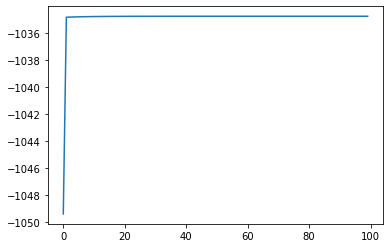

log likelihood after fitting: -1034.7539242965554
log likelihood of real generating model: -1059.7229160265022
best state sequence for  [0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


In [86]:
fit_coin()

The problem with the above algorithms is *underflow*: after all, $\alpha$ and $\beta$ are small numbers ($<1$) and hence, for long sequences, the training algorithm will lead to zero for $\alpha$ really soon, meaning that all multiplications will be zero from that point on. To solve this issue, we will do the following:

- For the Viterbi algorithm we will use logs, since it only involve multiplications. Hence, we turn the multiplications into sums and avoid the underflow problem.

- For the Baum-Welch algorithm, we will use scaling. For this, we will use a scale factor $c_t\,, t=1,...,T$

## Tensorization

Trying to run the forward and backward algorithms in general for an arbitrary sequence of length 30 (such as the one here) leads to an out-of-memory situation. 
We will therefore substitute the value of the sequence at each timestep.

In [12]:
import numpy as np
from typing import Union, Optional, List

In [13]:
# create a valid random markov matrix
def random_normalized(dim1, dim2):
    """
    Creates a matrix of random numbers that are compatible with Markov
    (namely, they rows sum up to 1)
    """
    random_matrix = np.random.rand(dim1, dim2)
    #divide by sum over rows to make rows add up to 1 (Markov matrix)
    return random_matrix/random_matrix.sum(axis=1, keepdims=True)

def load_data(data_path='./coin_data.txt'):
    X = list()
    for line in open(data_path):
        x = [1 if elm == 'H' else 0 for elm in line.rstrip()]
        X.append(x)
    return np.array(X)

def generate_initial_parameters(vocab_size,
                                num_hidden_states,
                                random_seed=True):
    if random_seed:
        np.random.seed(123)

    # initialize pi, A and B
    pi = (np.ones(num_hidden_states)/num_hidden_states).reshape(num_hidden_states,1) # uniform distirbution for pi
    A = random_normalized(num_hidden_states,num_hidden_states)
    B = random_normalized(num_hidden_states, vocab_size)

    return pi, A, B

In [14]:
X_data = load_data()
print(X_data.shape) # 50 samples of 30 timesteps each
VOCAB_SIZE = max(max(x) for x in X_data) + 1 # 2 different observable states
NUM_SEQS, SEQ_LENGTH = X_data.shape
M_ = 2 # assume 2-dim hidden space

(50, 30)


### Forward algotihm for fixed input sequence

Note for example that $$ \alpha(t=1, j) = \pi_j B(j, x_1)\,,$$ where $x_1$ is just the observation associated to the first timestep. We will substitute explicitly this observation. Now, our dataset does not contain only one observation, but $N = 50$ of them. To vectorize everything, we will substitute the $N$ samples of $x_1$ observed.

This logic will be applied to the recursive algorithm as well.

In [15]:
def alpha_initial(input_sequences: np.ndarray, 
                    pi: Union[List, np.ndarray], 
                    B: Union[List, np.ndarray]) -> np.ndarray:
    '''
    Computes the value of alpha associated to initial time t=1
    
    Parameters
        input_sequences: np.ndarray
            Input set of sequences, i.e. the training data
        pi: Union[List, np.ndarray]
            Initial vector of probabilities (i.e. p(z_1)) for each possible state of z_1
        B:  Union[List, np.ndarray]
            time-independent matrix of transition probabiltiies p(x_t|z_t) for each x- and z-states

    Return
        np.ndarray: initial value of alpha (namely, alpha_1)
    '''
    assert np.isclose(np.sum(pi), 1), "the sum of probabilities of initial latent states must add up to 1"
    assert (np.isclose(B.sum(axis=1), 1)).all(), "the total probability of a given observed state must be 1"
    # element-wise product with B evaluated on x(t=1) for all the rows (all the samples) at once
    # alpha_initial will end up having dimension M x N, where N is the total number of samples
    return np.multiply(pi, B[:,X_data[:,0]])

def beta_initial(A_dim: int, num_sequences: int) -> np.ndarray:
    '''
    Computes the value of beta associated to initial time t=T

    Parameters
        A_dim: int
            dimension of matrix A (namely, M in the above notation)

    Return
        np.ndarray: initial value of beta (namely, beta_1)
    '''
    return np.ones(shape=(A_dim, num_sequences)) # column vector of ones (one component per each z-state)


def forward_algo_input_fixed(
                    input_sequences: np.ndarray, 
                    A: Union[List, np.ndarray], 
                    B: Union[List, np.ndarray], 
                    alpha_ini: np.ndarray
                    ) -> List[np.ndarray]:

    ''' 
    This is the forward algorithm as implemented in notebook forward_algo.ipynb
    but with the input sequences evaluated whenever possible to make the problem
    computationally light

    Parameters
        input_sequences: np.ndarray
            Input set of sequences, i.e. the training data
        A:  Union[List, np.ndarray]
            Initial vector of probabilities (i.e. p(z_1)) for each possible state of z_1
        B:  Union[List, np.ndarray]
            time-independent matrix of transition probabiltiies p(x_t|z_t) for each x- and z-states
        alpha_ini: np,ndarray
            The value of alpha(t=1, z_1)
    Return
        List[np.ndarray]: list of alphas of the form 
        [alpha(t=1, z_1),..., alpha(t=T-1, z_{T-1}), alpha(t=T, z_T)]
    '''
    sequence_length = input_sequences.shape[1]
    A = np.array(A)
    B = np.array(B)
    assert isinstance(sequence_length, int), 'the length of the sequence must be an integer number'
    assert alpha_ini.shape[0] == A.shape[0], 'the length of the first axis of alpha_ini must be the rows of A'

    alphas_list = [alpha_ini] 
    for t_ in range(1,sequence_length):
        # np.einsum('ij,il->jl', A, alphas_list[t_-1]) gives the first part of the algorithm
        # factor1_jt = sum_i A_ij alpha(i,t) -> shape M x N
        # The second part of the formula np.multiply(B[:, input_sequences[:,t_]], factor1)
        # gives B(j, x_t) * factor1_jt
        alphas_list.append(np.multiply(B[:, input_sequences[:,t_]], 
                                        np.einsum('ij,il->jl', A, alphas_list[t_-1])))
    #alpha list has shape T x M x N
    return np.array(alphas_list)

def backward_algo_input_fixed(input_sequences: np.ndarray, 
                    A: Union[List, np.ndarray], 
                    B: Union[List, np.ndarray], 
                    beta_ini: np.ndarray
                    ) -> List[np.ndarray]:

    '''
    Computes a set of alphas following the (recursive) forward algorithm

    Parameters
        input_sequences: np.ndarray
            Input set of sequences, i.e. the training data
        A:  Union[List, np.ndarray]
            Initial vector of probabilities (i.e. p(z_1)) for each possible state of z_1
        B:  Union[List, np.ndarray]
            time-independent matrix of transition probabiltiies p(x_t|z_t) for each x- and z-states
        alpha_ini: np,ndarray
            The value of alpha(t=1, z_1)
    Return
        List[np.ndarray]: list of betas of the form 
        [beta(t=1, z_1), ..., beta(t=T-1, z_{T-1}), beta(t=T, z_T)]
    '''
    sequence_length = input_sequences.shape[1]
    A = np.array(A)
    B = np.array(B)
    assert isinstance(sequence_length, int), 'the length of the sequence must be an integer number'
    assert beta_ini.shape[0] == A.shape[0], 'the length of the first axis of beta_ini must be the rows of A'

    # initialize betas list
    betas_list = [0]*sequence_length
    betas_list[-1] = beta_ini #beta_ini will be a M x N matrix of 1s
    for t_ in reversed(range(1,sequence_length)):
        # note that we don't use t+1 when indexing beta because 
        # python starts counting indexes from 0: reversed(range(0,sequence_length))
        # goes from sequence_length-1 to 0. The last index of betas_list
        # is also sequence_length-1
        exps1 = np.einsum('ij,js,jl->isl', A, B[:, input_sequences[:,t_]], betas_list[t_])
        # force (column of B) = (column of betas_list[t_]) = x_{t+1}  
        # i.e pick diagonal for first and last indices: s = l above, without summing over s!
        betas_list[t_-1] = np.diagonal(exps1, axis1=len(exps1.shape)-2, axis2=len(exps1.shape)-1)
        # note that index associated to z is first index of beta
        # (this is so also for beta_ini)
    return np.array(betas_list)

def probability_fixed_input_sequence(alpha: np.ndarray):
    '''
    Computes the probability of a fixed sequence of x states given an alpha 
    (this alpha is suppossed to correspond to alpha(t=T, z_T))

    Parameters:
        alpha: np.ndarray
            A tensor with dimensions (M, K, K,...,K)
    Returns:
        np.ndarray:
            A tensor with dimension (K, K,...,K)
    '''
    # sum alpha along the first direction (that would correspond to z_T)
    # returns probability for arbitrary set of x
    # (note the ordering: ijk... will correspond to x_T, x_{T-1}, x_{T-2},...)
    #return alpha.sum(axis=0)
    return np.einsum('i...->...', alpha)

In [16]:
pi_, A_, B_ = generate_initial_parameters(vocab_size=VOCAB_SIZE, num_hidden_states=M_)

**Example: Forward algorithm**

For a given sequence (given row) 

$$B(i,x_2) \rightarrow M \times 1$$
$$ \alpha(t=1,i) \rightarrow M \times 1$$
$$ A(j,i) \rightarrow M \times M$$
Recall that:
$$\alpha(t+1, i) = B(i, x_{t+1}) \sum_j^M A(j,i) \alpha(t, j)$$

In [7]:
alpha_ini = alpha_initial(X_data, pi_, B_)

In [8]:
# Example: 
# third sequence (n=3) only for z=2 (i.e. alpha(t=2, z=2))
assd=0
for i in range(2):
    assd += A_[i,1]*alpha_ini[i,2] #z, t and n start from 0!

B_[1, X_data[2,1]]*assd

0.17681246697497588

In [9]:
# compute the full list of alphas for all N
alpha_list = forward_algo_input_fixed(X_data, A_, B_, alpha_ini)
alpha_list[1][1,2] #alpha for t=2, z=2 and n=3

0.17681246697497588

In [10]:
assert B_[1, X_data[2,1]]*assd == alpha_list[1][1,2] #alpha for t=2, z=2 and n=3

In [11]:
assert (probability_fixed_input_sequence(alpha_list[-1]) > 0).all()
assert (probability_fixed_input_sequence(alpha_list[-1]) < 1).all()

In [12]:
prob = probability_fixed_input_sequence(alpha_list[-1])

**Example: Backward algorithm**

For a given sequence 

$$B(i,x_{29}) \rightarrow M \times 1$$
$$ \beta(t=T,i) \rightarrow M \times 1$$
$$ A(j,i) \rightarrow M \times M$$
Recall that:
$$\beta(t, i) = \sum_j^M A(i,j)B(j, x_{t+1})\beta(t+1, j)$$

In [13]:
beta_ini = beta_initial(M_, NUM_SEQS)
beta_ini.shape

(2, 50)

In [14]:
# z=2, n=3, t=29 from  beta_ini (recall that beta_ini corresponds to t=T=30)
basse = 0
for j in range(M_):
    basse += A_[1,j]*B_[j, X_data[2,-1]]*beta_ini[j, 2]
basse

0.6007470210010455

In [15]:
beta_list = backward_algo_input_fixed(X_data, A_, B_, beta_ini)
beta_list[-2][1,2] # dimension T x M x N

0.6007470210010455

In [16]:
assert basse == beta_list[-2][1,2]

## Update $\pi$ 


In [324]:
def update_pi(alpha_list: np.ndarray, beta_list: np.ndarray) -> np.ndarray:
    '''
    Formula to update \pi according to Baum Welch

    Three equivalent ways

    Method 1: 
        np.multiply(beta_list[0]/prob,alpha_list[0]).mean(axis=1)
        
    Method 2:
        llo = 0
        for n in range(NUM_SEQS):
            llo += beta_list[0][:,n] * alpha_list[0][:, n]/prob[n]
        llo/NUM_SEQS

    Method 3:
        ss = np.diag(np.einsum('ij,lj', beta_list[0]/prob, alpha_list[0]))
        ss/NUM_SEQS

    Parameters:
        alpha_list: np.ndarray
            A tensor with dimensions (T, M, N)
        beta_list: np.ndarray
            A tensor with dimensions (T, M, N)
    Returns:
        np.ndarray:
            A tensor with dimension (M, 1)
    '''
    prob = probability_fixed_input_sequence(alpha_list[-1])
    return (np.multiply(beta_list[0]/prob, alpha_list[0]).mean(axis=1)).reshape(beta_list.shape[1],1)

In [237]:
hmm = HMM(2)
hmm.pi = pi_
hmm.A = A_
hmm.B = B_
hmm.fit(X_data, max_iter=1)

initial values: [0.5 0.5] [[0.7087962  0.2912038 ]
 [0.29152056 0.70847944]] [[0.62969057 0.37030943]
 [0.58883752 0.41116248]]
it: 0
NUMERATOR [[503.76144211 211.15307487]
 [211.3125875  523.77289552]]
DENOMINATOR [[714.91451698]
 [735.08548302]]
ITERATION: 0
A: [[0.7046457  0.2953543 ]
 [0.28746669 0.71253331]]
check A: [1. 1.]
B: [[0.56095853 0.43904147]
 [0.52091592 0.47908408]]
check B: [1. 1.]
pi: [0.49581661 0.50418339]
check pi: 1.0


/tmp/ipykernel_2321/3462682197.py:60: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.pi = np.sum((alphas[n][0] * betas[n][0])/P[n] for n in range(num_sequences))/num_sequences


NameError: name 'plt' is not defined

## Update A

$$ 

A_{ij} = \frac{\sum_{n=1}^N \frac{1}{P_n} \sum_{t=1}^{T_n-1}\alpha_n(t,i)A_{ij}B_{j, x_n(t+1)}\beta_n(t+1,j)}{\sum_{n=1}^N \frac{1}{P_n} \sum_{t=1}^{T_n-1}\alpha_n(t,i)\beta_n(t,i)}\,,\\

$$

In [341]:
def update_A(input_sequences: np.ndarray, 
            alpha_list: np.ndarray, 
            beta_list: np.ndarray,
            A_old: np.ndarray,
            B_old: np.ndarray) -> np.ndarray:

    prob = probability_fixed_input_sequence(alpha_list[-1])

    # be careful with reshape! It does not move axis directly!
    # use np.moveaxis to turn shape (a,b,c) into (b,c,a), for example
    # turn dimension of B_old[:, input_sequences[:,1:]] into shape of beta_list[1:,:,:]
    interm_ = np.moveaxis(B_old[:, input_sequences[:,1:]],-1,0)
    # note that in the formula B(j,x_{n,t+1}) involves th eexact same indices as
    # beta_n(t,j), so we can multiply element by element
    # also divide by P_n straight away (see formula)
    beta_B = (interm_*beta_list[1:,:,:]/prob)

    # We use the X[1:,:,:] in the indices to denote that what enters is t+1

    # A_{ij} does not involve t, n, so we move it away from sums
    # sum in t goes from t=1 to T-1. This involves using alpha_list[:-1,:,:]
    # (t+1) goes from 1 to T, that explain the indices of B and beta above
    # alpha coes with index z=i and beta_B with z=j, that is why those indices
    # remain free to match with A_old{ij}
    numerator = A_old*np.einsum('ijk,irk->jr', alpha_list[:-1,:,:], beta_B) # dim MxM
    '''
    Another way:
        numerator = np.einsum('ijk,lm,nki,irk->jlmnr', alpha_list[:-1,:,:], A_, B_[:, input_sequences[:,1:]], beta_list[1:,:,:]/prob)
        numerator = np.diagonal(numerator, axis1=0, axis2=1)
        numerator = np.diagonal(numerator, axis1=0, axis2=1)
        numerator = np.diagonal(numerator, axis1=0, axis2=len(numerator.shape)-1)
    '''
    denominator = np.diag(np.einsum('ikj,isj->ks', alpha_list[:-1,:,:], beta_list[:-1,:,:]/prob)) # dim M 

    # see formula: we want numerator[i,j]/denominator[i]
    #reshape denominator to acquire dimension Mx1
    return numerator/denominator.reshape(denominator.shape[0],1)

In [275]:
update_A(X_data, alpha_list, beta_list)

array([[0.7046457 , 0.2953543 ],
       [0.28746669, 0.71253331]])

## Update B

$$
B_{jk} = \frac{\sum_{n=1}^N \frac{1}{P_n} \sum_{t=1}^{T_n}\alpha_n(t,j)\beta_n(t,j) \mathbb{1}(x_n(t)=k)}{\sum_{n=1}^N \frac{1}{P_n} \sum_{t=1}^{T_n}\alpha_n(t,j)\beta_n(t,j)}\,,
$$

In [342]:
def update_B(input_sequences: np.ndarray, 
            alpha_list: np.ndarray, 
            beta_list: np.ndarray) -> np.ndarray:

    prob = probability_fixed_input_sequence(alpha_list[-1])

    vocab_size = max(max(x) for x in input_sequences) + 1
    # define delta-type object, that is only 1 whenever k equals x_n(t)
    mask_u = list()
    for k_ in range(vocab_size):
        # place 1. if condition is fullfilled, 0. otherwise
        mask_u.append(np.where(input_sequences == k_, 1., 0.))
    mask_u = np.array(mask_u) # dim KxNxT

    # indices of alpha_list and beta_list coincide, so we can multiply elemen by element
    unmasked_num = (alpha_list*beta_list/prob)
    # mask numerator with mask_u
    numerator = np.einsum('ijk,lki->jl', unmasked_num, mask_u) # dim MxK
    #denominator is just the unmasked numerator summed over t and n
    denominator = np.einsum('ijk->j', unmasked_num) # dim M 

    # see formula: we want numerator[j,k]/denominator[j]
    #reshape denominator to acquire dimension Mx1
    return numerator/denominator.reshape(denominator.shape[0],1)

In [311]:
update_B(X_data, alpha_list, beta_list)

array([[0.56095853, 0.43904147],
       [0.52091592, 0.47908408]])

## Tensorized Viterbi

$$ \delta(t=1, j) = \pi(j) B(j,x_1)$$

$$ \delta(t, j) = \text{max}_{i\in \{1,...,M\}} \left[\delta(t-1,i) A(i,j)\right] B(j, x_t)\,, \hspace{1cm} j=1,...,M $$

$$p^* = \text{max}_{i\in \{1,...,M\}} \delta (t=T, j) $$

In [23]:
delta_init = np.multiply(pi_, B_[:, X_data[:,0]])
delta_init.shape # M x N

(2, 50)

In [104]:
ss = np.einsum('ij,kl ->ijkl', A_, delta_init)
ssd = np.diagonal(ss, axis1=0, axis2=2) 
ssdm = np.max(ssd, axis=2)

In [111]:
np.argmax(ssd, axis=2).shape

(2, 50)

In [ ]:
### Backtrack
states = np.zeros(T, dtype=np.int32)
states[T-1] = np.argmax(delta[T-1])
for t in range(T-2,-1,-1):
    states[t] = psi[t+1, states[t+1]]

In [112]:
ssdm.shape

(2, 50)

In [109]:
(ssdm * B_[:, X_data[:, 1]]).shape


(2, 50)

In [96]:
print(ssd[:,1,0])
print(ssd[:,1,1])

[0.13123696 0.05391776]
[0.05993116 0.14565008]


In [ ]:
delta_1 = np.multiply(delta_init, )

In [244]:
def viterbi(input_sequences: np.ndarray, 
            pi: np.ndarray,
            A: np.ndarray,
            B: np.ndarray) -> np.ndarray:

    sequence_length = input_sequences.shape[1]
    A = np.array(A)
    B = np.array(B)
    pi = np.array(pi).reshape(B.shape[0], 1)

    # define initial delta
    delta_ini = np.multiply(pi, B[:, input_sequences[:, 0]]) # M x N

    deltas_list = [delta_ini]
    # initial psi = 0 with dim MxN
    psis_list = [np.zeros(shape=(B.shape[0], input_sequences.shape[0]))] 
    for t_ in range(1,sequence_length):
        # compute A(i,j)*delta(t-1, i) (no summation!) by first getting all indices
        # and then picking the appropriate diagonal (axis=0 (i) with axis=2 (k))
        extend_elmnt_prod = np.einsum('ij,kl->ijkl', A_, deltas_list[t_-1])
        elmnt_prod = np.diagonal(extend_elmnt_prod, axis1=0, axis2=2) # M(j) x N x M(i)
        # get maximum in the direction of i (axis=2)
        max_elmnt_prod = np.max(elmnt_prod, axis=2) # M(j) x N
        # multiply by B[:, input_sequences[:, t]] (also with dim = M x N)
        # and append
        deltas_list.append(np.multiply(max_elmnt_prod, 
                    B[:, input_sequences[:, t_]])) # element appended has dim= M x N
        # append psi[t,j]
        psis_list.append(np.argmax(elmnt_prod, axis=2)) # M(j) x N
    return deltas_list, psis_list
    ### Backtracking algorithm
    optim_states = np.zeros_like(input_sequences) # N x T
    #[np.zeros(shape=(1,input_sequences.shape[0]))]*sequence_length
    #optim_states[-1] = np.argmax(deltas_list[-1], axis=0) # argmax(delta(T)) has dim = N
    optim_states[:,-1] = np.argmax(deltas_list[-1], axis=0) # argmax(delta(T)) has dim = N
    #return np.array(psis_list), optim_states
    # go barckards
    for t_ in reversed(range(1,sequence_length)):
        # preserve time direction
        # first compute general tensor with all indices
        # and then pick diagonal: so for example, for t_=29
        #you get np.array(psis_list)[29, optim_states[i,29], i] for i=0,...,N-1
        optim_states[:,t_-1] = np.diagonal(np.array(psis_list)[t_, 
                                                    optim_states[:, t_], :]) # diag of N x N matrix

    return np.array(psis_list), optim_states

In [277]:
delta_ini = np.multiply(pi_, B_[:, X_data[:, 0]]) # M x N
deltas_list = [delta_ini]
extend_elmnt_prod = np.einsum('ij,kl->ijkl', A_, deltas_list[0])
# A(i,j)delta(0,i)
elmnt_prod = np.diagonal(extend_elmnt_prod, axis1=0, axis2=2)
max_elmnt_prod = np.max(elmnt_prod, axis=2)
argmax_elmnt_prod = np.argmax(elmnt_prod, axis=2)

In [283]:
argmax_elmnt_prod[0, :10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [284]:
elmnt_prod[0,:10,:]

array([[0.22316114, 0.08582912],
       [0.13123696, 0.05993116],
       [0.22316114, 0.08582912],
       [0.22316114, 0.08582912],
       [0.13123696, 0.05993116],
       [0.22316114, 0.08582912],
       [0.22316114, 0.08582912],
       [0.13123696, 0.05993116],
       [0.22316114, 0.08582912],
       [0.22316114, 0.08582912]])

In [285]:
elmnt_prod

array([[[0.22316114, 0.08582912],
        [0.13123696, 0.05993116],
        [0.22316114, 0.08582912],
        [0.22316114, 0.08582912],
        [0.13123696, 0.05993116],
        [0.22316114, 0.08582912],
        [0.22316114, 0.08582912],
        [0.13123696, 0.05993116],
        [0.22316114, 0.08582912],
        [0.22316114, 0.08582912],
        [0.22316114, 0.08582912],
        [0.13123696, 0.05993116],
        [0.22316114, 0.08582912],
        [0.22316114, 0.08582912],
        [0.22316114, 0.08582912],
        [0.13123696, 0.05993116],
        [0.13123696, 0.05993116],
        [0.22316114, 0.08582912],
        [0.22316114, 0.08582912],
        [0.22316114, 0.08582912],
        [0.13123696, 0.05993116],
        [0.13123696, 0.05993116],
        [0.22316114, 0.08582912],
        [0.13123696, 0.05993116],
        [0.13123696, 0.05993116],
        [0.22316114, 0.08582912],
        [0.13123696, 0.05993116],
        [0.22316114, 0.08582912],
        [0.22316114, 0.08582912],
        [0.131

In [275]:
max_elmnt_prod

array([[0.22316114, 0.13123696, 0.22316114, 0.22316114, 0.13123696,
        0.22316114, 0.22316114, 0.13123696, 0.22316114, 0.22316114,
        0.22316114, 0.13123696, 0.22316114, 0.22316114, 0.22316114,
        0.13123696, 0.13123696, 0.22316114, 0.22316114, 0.22316114,
        0.13123696, 0.13123696, 0.22316114, 0.13123696, 0.13123696,
        0.22316114, 0.13123696, 0.22316114, 0.22316114, 0.13123696,
        0.13123696, 0.13123696, 0.22316114, 0.22316114, 0.22316114,
        0.22316114, 0.22316114, 0.13123696, 0.13123696, 0.13123696,
        0.13123696, 0.22316114, 0.13123696, 0.22316114, 0.13123696,
        0.13123696, 0.13123696, 0.13123696, 0.22316114, 0.22316114],
       [0.20858964, 0.14565008, 0.20858964, 0.20858964, 0.14565008,
        0.20858964, 0.20858964, 0.14565008, 0.20858964, 0.20858964,
        0.20858964, 0.14565008, 0.20858964, 0.20858964, 0.20858964,
        0.14565008, 0.14565008, 0.20858964, 0.20858964, 0.20858964,
        0.14565008, 0.14565008, 0.20858964, 0.1

In [245]:
psps, opt_st = viterbi(X_data, pi_, A_, B_)

In [254]:
opt_st

[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0

In [251]:
psps[-1]

array([[1.28834417e-14, 5.80204314e-15, 6.33459904e-14, 1.65783703e-15,
        2.19075750e-14, 2.10595020e-15, 2.19075750e-14, 1.65783703e-15,
        1.07716328e-13, 2.81905953e-15, 1.28834417e-14, 1.28834417e-14,
        1.28834417e-14, 1.68313051e-15, 7.57651495e-15, 3.72526111e-14,
        3.01599134e-15, 7.57651495e-15, 3.72526111e-14, 6.33459904e-14,
        1.28834417e-14, 6.33459904e-14, 7.57651495e-15, 2.19075750e-14,
        2.19075750e-14, 3.72526111e-14, 1.82921516e-15, 1.07716328e-13,
        1.07716328e-13, 7.57651495e-15, 3.72526111e-14, 6.33459904e-14,
        1.28834417e-14, 3.72526111e-14, 7.57651495e-15, 1.96844033e-15,
        3.72526111e-14, 1.28834417e-14, 6.33459904e-14, 2.17192693e-15,
        1.28834417e-14, 1.07716328e-13, 1.28834417e-14, 2.19075750e-14,
        6.33459904e-14, 1.28834417e-14, 4.45560900e-15, 4.45560900e-15,
        6.33459904e-14, 6.33459904e-14],
       [1.88181346e-14, 9.17513760e-15, 5.52742108e-14, 4.47351193e-15,
        2.69499873e-14,

In [236]:
opt_st[4,:]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [219]:
ll=[]
for i in range(50):
    ll.append(psps[29,opt_st[i,29],i])

len(ll)

50

In [222]:
np.diagonal(psps[29,opt_st[:,29],:])

array([1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.])

In [215]:
np.einsum('ijk,lm->ijklm', )

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0])

In [198]:
psps[29, : ,:].shape

(2, 50)

In [166]:
psps.shape

(30, 2, 50)

In [185]:
psps_s = psps[:,:,1]
kk = np.array(opt_st)[-1][1]

/tmp/ipykernel_207/3495326239.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kk = np.array(opt_st)[-1][1]


In [187]:
psps_s[29,1]

1.0

In [181]:
np.array(opt_st)[-1]

/tmp/ipykernel_207/2409934690.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(opt_st)[-1]


array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0])

In [184]:
psps[29, :, opt_st[29]].shape

(50, 2)

In [153]:
for t_ in reversed(range(1,X_data.shape[1])):
    print(t_)
    # preserve time direction
    opt_st[t_-1] =np.array(psps)[t_, opt_st[t_], :]

29
28


IndexError: arrays used as indices must be of integer (or boolean) type

In [138]:
psps.shape


(30, 2, 50)

## Define tensorized HMM

In [414]:
class TensorizedHMM:

    def __init__(self, num_hidden_states):
        self.M = num_hidden_states

    def fit(self, X: np.ndarray, max_iter: int = 30, verbose: bool = False):
        """
        Parameters:
            max_iter: maximum number of EM iterations to allow
            X: stores a set of observed sequences as rows.
        """

        # include seed for reproducibility
        np.random.seed(123)

        # vocabulary size (classes from 0 to V-1)
        # (number of x states = K is the maximum number 
        # of states in the training set found for a sequence)
        vocab_size = max(max(x) for x in X) + 1 
        num_sequences = len(X)

        # initialize pi, A and B
        self.pi, self.A, self.B = generate_initial_parameters(
                                                vocab_size=vocab_size, 
                                                num_hidden_states=self.M)
        # store cost
        costs = list()
        for it in range(max_iter):
            #if it % 10 == 0:
            #    print('it:', it)

            #### Compute alpha
            alpha_ini = alpha_initial(X, self.pi, self.B)
            # compute the full list of alphas for all N
            self.alpha_list = forward_algo_input_fixed(X, self.A, self.B, alpha_ini)

            #### compute beta
            beta_ini = beta_initial(self.M, num_sequences)
            self.beta_list = backward_algo_input_fixed(X, self.A, self.B, beta_ini)

            #### compute cost
            P = probability_fixed_input_sequence(self.alpha_list[-1])
            cost = np.sum(np.log(P))
            costs.append(cost)

            #### Reestimate pi, A and B
            self.pi = update_pi(self.alpha_list, self.beta_list)
            self.A = update_A(X, self.alpha_list, self.beta_list, self.A, self.B)
            self.B = update_B(X, self.alpha_list, self.beta_list)

            if verbose:
                ## print & plot final estimates/costs
                print('ITERATION:', it)
                print("A:", self.A)
                print('check A:', self.A.sum(axis=1))
                print("B:", self.B)
                print('check B:', self.B.sum(axis=1))
                print("pi:", self.pi)
                print('check pi:', self.pi.sum())

        
        # plot costs
        #plt.plot(costs)
        #plt.show()

    def likelihood(self, x):
        '''
        Computes the probability (likelihood) of a sequence
        by means of the forward algorithm
        '''
        
        alpha_ini = alpha_initial(x, self.pi, self.B)
        # compute the full list of alphas for all N
        self.alpha_list = forward_algo_input_fixed(x, self.A, self.B, alpha_ini)

        return probability_fixed_input_sequence(self.alpha_list[-1])

    def likelihood_multi(self, X):
        '''
        Computes the probability (likelihood) for all the
        observations (sequences)
        '''
        #return np.array([self.likelihood(x) for x in X])
        return self.likelihood(X)

    def log_likelihood_multi(self, X):
        '''
        Computes the log likelihood of all the observations
        '''
        return np.log(self.likelihood_multi(X))

    def get_state_sequence(self, x):
        # TODO: TENSORIZE
        '''
        Computes the most probable set of hidden states given 
        observation sequence x using the Viterbi algorithm
        '''
        T = len(x)
        delta = np.zeros((T, self.M))
        psi = np.zeros((T, self.M))
        delta[0] = self.pi * self.B[:, x[0]]
        for t in range(1,T):
            for j in range(self.M):
                delta[t,j] = np.max(delta[t-1]*self.A[:,j])*self.B[j, x[t]]
                psi[t,j] = np.argmax(delta[t-1]*self.A[:,j])

        ### Backtrack
        states = np.zeros(T, dtype=np.int32)
        states[T-1] = np.argmax(delta[T-1])
        for t in range(T-2,-1,-1):
            states[t] = psi[t+1, states[t+1]]

        return states

## Comparison and speed

In [417]:
import matplotlib.pyplot as plt
import time
# the random state is fixed so that the initial state is identical.
thmm = TensorizedHMM(2)
hmm = HMM(2)

In [436]:
tensor_time_stats = dict()
for m_iter in [10,30,50]:
    tensor_time_stats[m_iter] = list()
    for exp_ in range(300):
        #if exp_ % 10 == 0:
        #    print(exp_)
        start = time.time()
        thmm = TensorizedHMM(2)
        thmm.fit(X_data, max_iter=m_iter)
        tensor_time_stats[m_iter].append(time.time()-start)

In [435]:
basic_time_stats = dict()
for m_iter in [10,30,50]:
    basic_time_stats[m_iter] = list()
    for exp_ in range(300):
        #if exp_ % 10 == 0:
        #    print(exp_)
        start = time.time()
        hmm = HMM(2)
        hmm.fit(X_data, max_iter=m_iter)
        basic_time_stats[m_iter].append(time.time()-start)

/tmp/ipykernel_2321/3611249952.py:59: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.pi = np.sum((alphas[n][0] * betas[n][0])/P[n] for n in range(num_sequences))/num_sequences


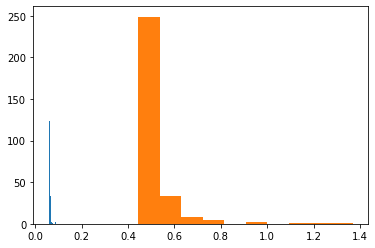

In [438]:
plt.hist(tensor_time_stats[30])
plt.hist(basic_time_stats[30])
plt.show()

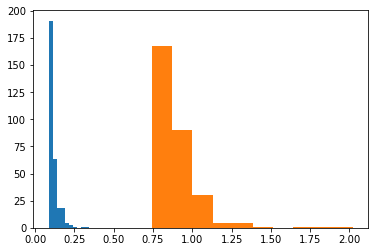

In [439]:
plt.hist(tensor_time_stats[50])
plt.hist(basic_time_stats[50])
plt.show()

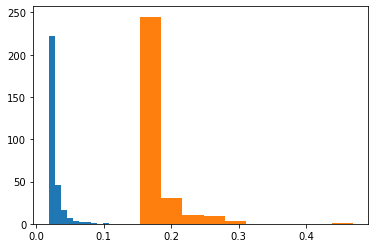

In [437]:
plt.hist(tensor_time_stats[10])
plt.hist(basic_time_stats[10])
plt.show()

In [432]:
print(np.max(tensor_time_stats))
print(np.max(basic_time_stats))

0.04507279396057129
0.27582740783691406
